In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.activity.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fexperimentsandconfigs%20https%3a%2f%2fwww.googleapis.com%2fauth%2fphotos.native&response_type=code

Enter your authorization code:
4/1AY0e-g58E24cQX8pAaITj76Ltz49u1TSmQfL9xPEXqvXFrTU9GGZRKCmQMA
Mounted at /content/drive


In [2]:
!pip install sentence_transformers
!pip install umap-learn
!pip install hdbscan

     |████████████████████████████████| 81kB 4.6MB/s 
     |████████████████████████████████| 2.3MB 11.1MB/s 
     |████████████████████████████████| 1.2MB 40.1MB/s 
     |████████████████████████████████| 901kB 45.2MB/s 
     |████████████████████████████████| 3.3MB 44.0MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-1.1.1-cp37-none-any.whl size=123338 sha256=32ae24ed33aa51587a772da625f0a1899098f174d0a2ba54ae9bf2c49ad0690b
  Stored in directory: /root/.cache/pip/wheels/5e/89/29/45e45adc162b50f97f71801e8b07947c9cfe2b3ae7dbf37896
Successfully built sentence-transformers
     |████████████████████████████████| 81kB 5.7MB/s 
     |████████████████████████████████| 1.2MB 13.1MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-cp37-none-any.whl size=76569 sha256=bc4df78a41da9b9908d6fd6cd0fabceb8fa874ed189a1b7b77577df1a6c2641c
  Stored in directory: /root/.cache/pip/wheels/ad/df/d5/a3691296ff779f25cd1cf415a3af954b987fb53111e3392cf4
  Created wheel 

# Punto 1

In [3]:
import json
import pandas as pd
import gensim
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import numpy as np
import nltk
import ssl
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
prefix = './drive/MyDrive/'
italian_path = prefix + 'datasets/italian/italianV1.json'
spanish_path = prefix + 'datasets/spanish/spanishV1.json'
english_path = prefix + 'datasets/english/englishSmall.json'


In [5]:
# VSCode
# english_path
file = open(english_path, 'r')
data = []
for line in file:
    data.append(json.loads(line))
english_raw = pd.json_normalize(data)

print(english_raw.shape)
english_raw.head(10)

(10000, 4)


,id,publication_date,source,text
0,1295929115770593287,1.597809e+09,twitter,Info Source:
1,1296738518216011777,1.598002e+09,twitter,#PostponeJEE_NEETSept #ProtestAgainstExamsInCO...
2,1252450676015198210,1.587442e+09,twitter,Coronavirus-spreader Chris Cuomo got a lecture...
3,1380684968880406528,1.618016e+09,twitter,Any military member that refuses to get vaccin...
4,1368958702150156290,1.615220e+09,twitter,#Covid19 is staying around for a while. your ...
5,1317169175203401735,1.602873e+09,twitter,LIES!!! LIES!!!
6,1288154256449708032,1.595955e+09,twitter,"@GregMannarino Deborah BirxWhite House ""Expert"""
7,1283867253222502400,1.594933e+09,twitter,Kayleigh McEnany: ‘Science Should Not Stand in...
8,1286909343909240832,1.595658e+09,twitter,Amazing effort from the guys! Please donate if...
9,1235895985009811461,1.583496e+09,twitter,@SulaiOdus They said it was suspended due to c...


In [6]:
'''
Turn text to Numpy Array
'''
texts_column = english_raw.loc[:,'text']
raw_texts = texts_column.values
raw_texts[0]

'Info Source: '

## Arquitectura 1

In [7]:
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('distilbert-base-nli-mean-tokens')
embeddings = model.encode(raw_texts, show_progress_bar=True)

### UMAP para reducir la dimensionalidad de los embeddings
#### Esto permite una mejor clasificación para el clustering

In [8]:
import umap.umap_ as umap
umap_embeddings = umap.UMAP(n_neighbors=30, 
                            n_components=5, 
                            metric='cosine').fit_transform(embeddings)

### HDBSCAN para el clustering

In [9]:
import hdbscan
cluster = hdbscan.HDBSCAN(min_cluster_size=60,
                          metric='euclidean',                      
                          cluster_selection_method='eom').fit(umap_embeddings)

### Visualisación de los clusters

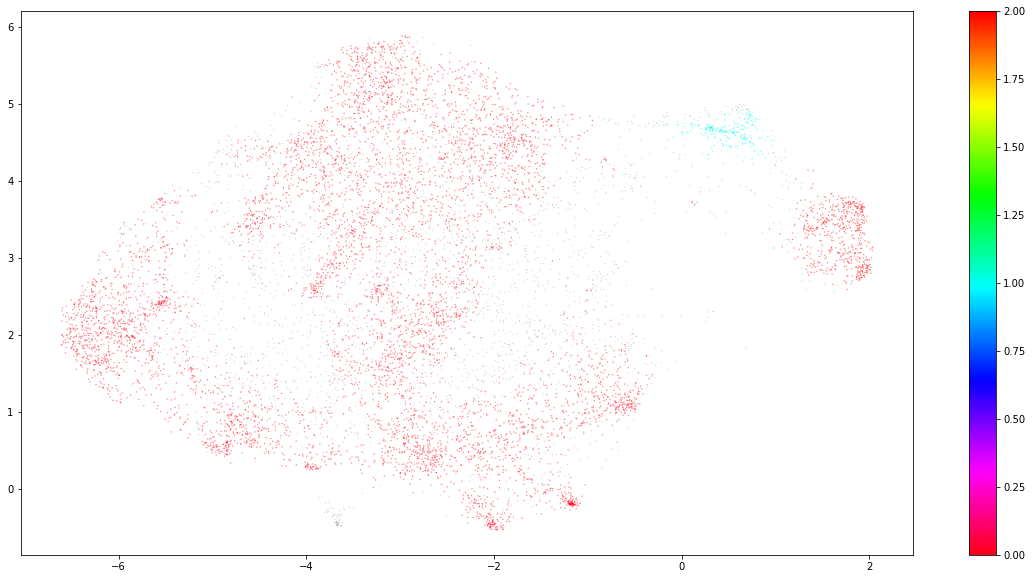

In [10]:
import matplotlib.pyplot as plt

# Prepare data
umap_data = umap.UMAP(n_neighbors=30, n_components=2, min_dist=0.0, metric='cosine').fit_transform(embeddings)
result = pd.DataFrame(umap_data, columns=['x', 'y'])
result['labels'] = cluster.labels_

# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

### c-TF-IDF

In [11]:
docs_df = pd.DataFrame(raw_texts, columns=["Doc"])
docs_df['Topic'] = cluster.labels_
docs_df['Doc_ID'] = range(len(docs_df))
docs_per_topic = docs_df.groupby(['Topic'], as_index = False).agg({'Doc': ' '.join})

In [12]:
def c_tf_idf(documents, m, ngram_range=(1, 1)):
    count = CountVectorizer(ngram_range=ngram_range, stop_words="english").fit(documents)
    t = count.transform(documents).toarray()
    w = t.sum(axis=1)
    tf = np.divide(t.T, w)
    sum_t = t.sum(axis=0)
    idf = np.log(np.divide(m, sum_t)).reshape(-1, 1)
    tf_idf = np.multiply(tf, idf)

    return tf_idf, count
  
tf_idf, count = c_tf_idf(docs_per_topic.Doc.values, m=len(raw_texts))

In [13]:

def extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20):
    words = count.get_feature_names()
    labels = list(docs_per_topic.Topic)
    tf_idf_transposed = tf_idf.T
    indices = tf_idf_transposed.argsort()[:, -n:]
    top_n_words = {label: [(words[j], tf_idf_transposed[i][j]) for j in indices[i]][::-1] for i, label in enumerate(labels)}
    return top_n_words

def extract_topic_sizes(df):
    topic_sizes = (df.groupby(['Topic'])
                     .Doc
                     .count()
                     .reset_index()
                     .rename({"Topic": "Topic", "Doc": "Size"}, axis='columns')
                     .sort_values("Size", ascending=False))
    return topic_sizes

top_n_words = extract_top_n_words_per_topic(tf_idf, count, docs_per_topic, n=20)
topic_sizes = extract_topic_sizes(docs_df); topic_sizes.head(10)

,Topic,Size
1,0,6645
0,-1,2547
3,2,566
2,1,242


In [14]:
for topic in topic_sizes['Topic']:
  if topic == -1:
    continue
  print(str([t[0] for t in top_n_words[topic][:10]]) + '\n')

['coronavirus', 'covid', '19', 'covid19', 'cases', 'new', 'trump', 'people', 'vaccine', 'amp']

['good', 'great', 'oh', 'read', 'news', 'just', 'thread', 'god', 'let', 'prayers']

['don', 'just', 'fucking', 'fuck', 'sad', 'holy', 'shit', 'terrible', 'dumbass', 'hell']



## Modelo a comparar escrito por Diegol (TODO: No se si se debe tocar)

In [ ]:
try:
     _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
     pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')#%% md

## Reading Files

In [ ]:
stemmer = SnowballStemmer("english")
'''
Write a function to perform the pre processing steps on the entire dataset
'''
def lemmatize_stemming(text):
    return stemmer.stem(WordNetLemmatizer().lemmatize(text, pos='v'))

# Tokenize and lemmatize
def preprocess(text):
    result=[]
    for token in gensim.utils.simple_preprocess(text) :
        if token not in gensim.parsing.preprocessing.STOPWORDS and len(token) > 3:
            result.append(lemmatize_stemming(token))

    return result

In [ ]:
processed_docs = []

for doc in raw_texts:
    processed_docs.append(preprocess(doc))

In [ ]:
'''
Preview 'processed_docs'
'''
print(processed_docs[:10])

[['info', 'sourc'], ['work'], ['coronavirus', 'spreader', 'chris', 'cuomo', 'lectur', 'break', 'quarantin', 'upset'], ['militari', 'member', 'refus', 'vaccin', 'baffl', 'shit', 'pump'], ['covid', 'stay', 'busi', 'covidsaf'], ['lie', 'lie'], ['gregmannarino', 'deborah', 'birxwhit', 'hous', 'expert'], ['kayleigh', 'mcenani', 'scienc', 'stand', 'reopen', 'school'], ['amaz', 'effort', 'guy', 'donat'], ['sulaiodus', 'say', 'suspend', 'coronavirus', 'media']]


In [ ]:
'''
Create a dictionary from 'processed_docs' containing the number of times a word appears
in the training set using gensim.corpora.Dictionary and call it 'dictionary'
'''
dictionary = gensim.corpora.Dictionary(processed_docs)

In [ ]:
'''
OPTIONAL STEP
Remove very rare and very common words:

- words appearing less than 15 times
- words appearing in more than 10% of all documents
'''
dictionary.filter_extremes(no_below=15, no_above=0.1, keep_n= 100000)

In [ ]:
'''
Create the Bag-of-words model for each document i.e for each document we create a dictionary reporting how many
words and how many times those words appear. Save this to 'bow_corpus'
'''
bow_corpus = [dictionary.doc2bow(doc) for doc in processed_docs]

In [ ]:
# LDA multicore
'''
Train your lda model using gensim.models.LdaMulticore and save it to 'lda_model'
'''
# TODO
lda_model =  gensim.models.LdaMulticore(bow_corpus,
                                   num_topics = 8,
                                   id2word = dictionary,
                                   passes = 10,
                                   workers = 2)

In [ ]:
'''
For each topic, we will explore the words occuring in that topic and its relative weight
'''
for idx, topic in lda_model.print_topics(-1):
    print("Topic: {} \nWords: {}".format(idx, topic ))
    print("\n")

Topic: 0 
Words: 0.022*"vaccin" + 0.013*"patient" + 0.012*"hous" + 0.012*"studi" + 0.010*"hospit" + 0.010*"research" + 0.009*"expert" + 0.009*"say" + 0.009*"doctor" + 0.008*"post"


Topic: 1 
Words: 0.028*"mask" + 0.019*"pandem" + 0.016*"china" + 0.014*"face" + 0.014*"wear" + 0.012*"govern" + 0.009*"market" + 0.008*"sign" + 0.007*"world" + 0.007*"wuhan"


Topic: 2 
Words: 0.068*"peopl" + 0.039*"like" + 0.019*"look" + 0.018*"think" + 0.013*"right" + 0.011*"kill" + 0.011*"fuck" + 0.011*"get" + 0.009*"long" + 0.009*"go"


Topic: 3 
Words: 0.040*"vaccin" + 0.020*"health" + 0.017*"help" + 0.012*"home" + 0.012*"pandem" + 0.011*"stay" + 0.011*"busi" + 0.010*"work" + 0.010*"worker" + 0.009*"care"


Topic: 4 
Words: 0.067*"case" + 0.046*"test" + 0.041*"death" + 0.028*"report" + 0.022*"posit" + 0.020*"updat" + 0.014*"number" + 0.013*"state" + 0.010*"news" + 0.010*"infect"


Topic: 5 
Words: 0.029*"know" + 0.020*"good" + 0.019*"come" + 0.018*"year" + 0.016*"go" + 0.011*"time" + 0.010*"hope" + 0.0